# F20PA

## Artificial Neural Network Model

In [1]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sklearn

In [2]:
# import the data
df = pd.read_csv("Monthly Rainfall Index and Flood Probability Kerala.csv")

df.head()

,SUBDIVISION,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANNUAL RAINFALL,FLOODS
0,KERALA,1901,28.7,44.7,51.6,160.0,174.7,824.6,743.0,357.5,197.7,266.9,350.8,48.4,3248.6,YES
1,KERALA,1902,6.7,2.6,57.3,83.9,134.5,390.9,1205.0,315.8,491.6,358.4,158.3,121.5,3326.6,YES
2,KERALA,1903,3.2,18.6,3.1,83.6,249.7,558.6,1022.5,420.2,341.8,354.1,157.0,59.0,3271.2,YES
3,KERALA,1904,23.7,3.0,32.2,71.5,235.7,1098.2,725.5,351.8,222.7,328.1,33.9,3.3,3129.7,YES
4,KERALA,1905,1.2,22.3,9.4,105.9,263.3,850.2,520.5,293.6,217.2,383.5,74.4,0.2,2741.6,NO


### Exploratory Data Analysis

In [3]:
# get a summary of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SUBDIVISION       118 non-null    object 
 1   YEAR              118 non-null    int64  
 2   JAN               118 non-null    float64
 3   FEB               118 non-null    float64
 4   MAR               118 non-null    float64
 5   APR               118 non-null    float64
 6   MAY               118 non-null    float64
 7   JUN               118 non-null    float64
 8   JUL               118 non-null    float64
 9   AUG               118 non-null    float64
 10  SEP               118 non-null    float64
 11  OCT               118 non-null    float64
 12  NOV               118 non-null    float64
 13  DEC               118 non-null    float64
 14   ANNUAL RAINFALL  118 non-null    float64
 15  FLOODS            118 non-null    object 
dtypes: float64(13), int64(1), object(2)
memory u

We can see that there are no missing values in the dataset

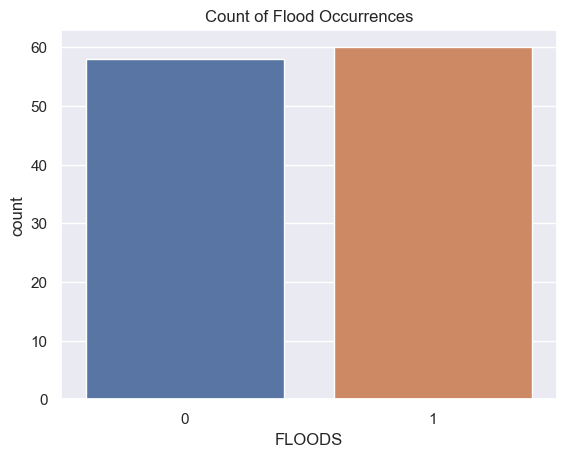

In [58]:
# display the count of floods and no-floods
sns.countplot(data=df, x='FLOODS')
plt.title('Count of Flood Occurrences')
plt.show()

The number of flood and non-flood instances are almost equal.

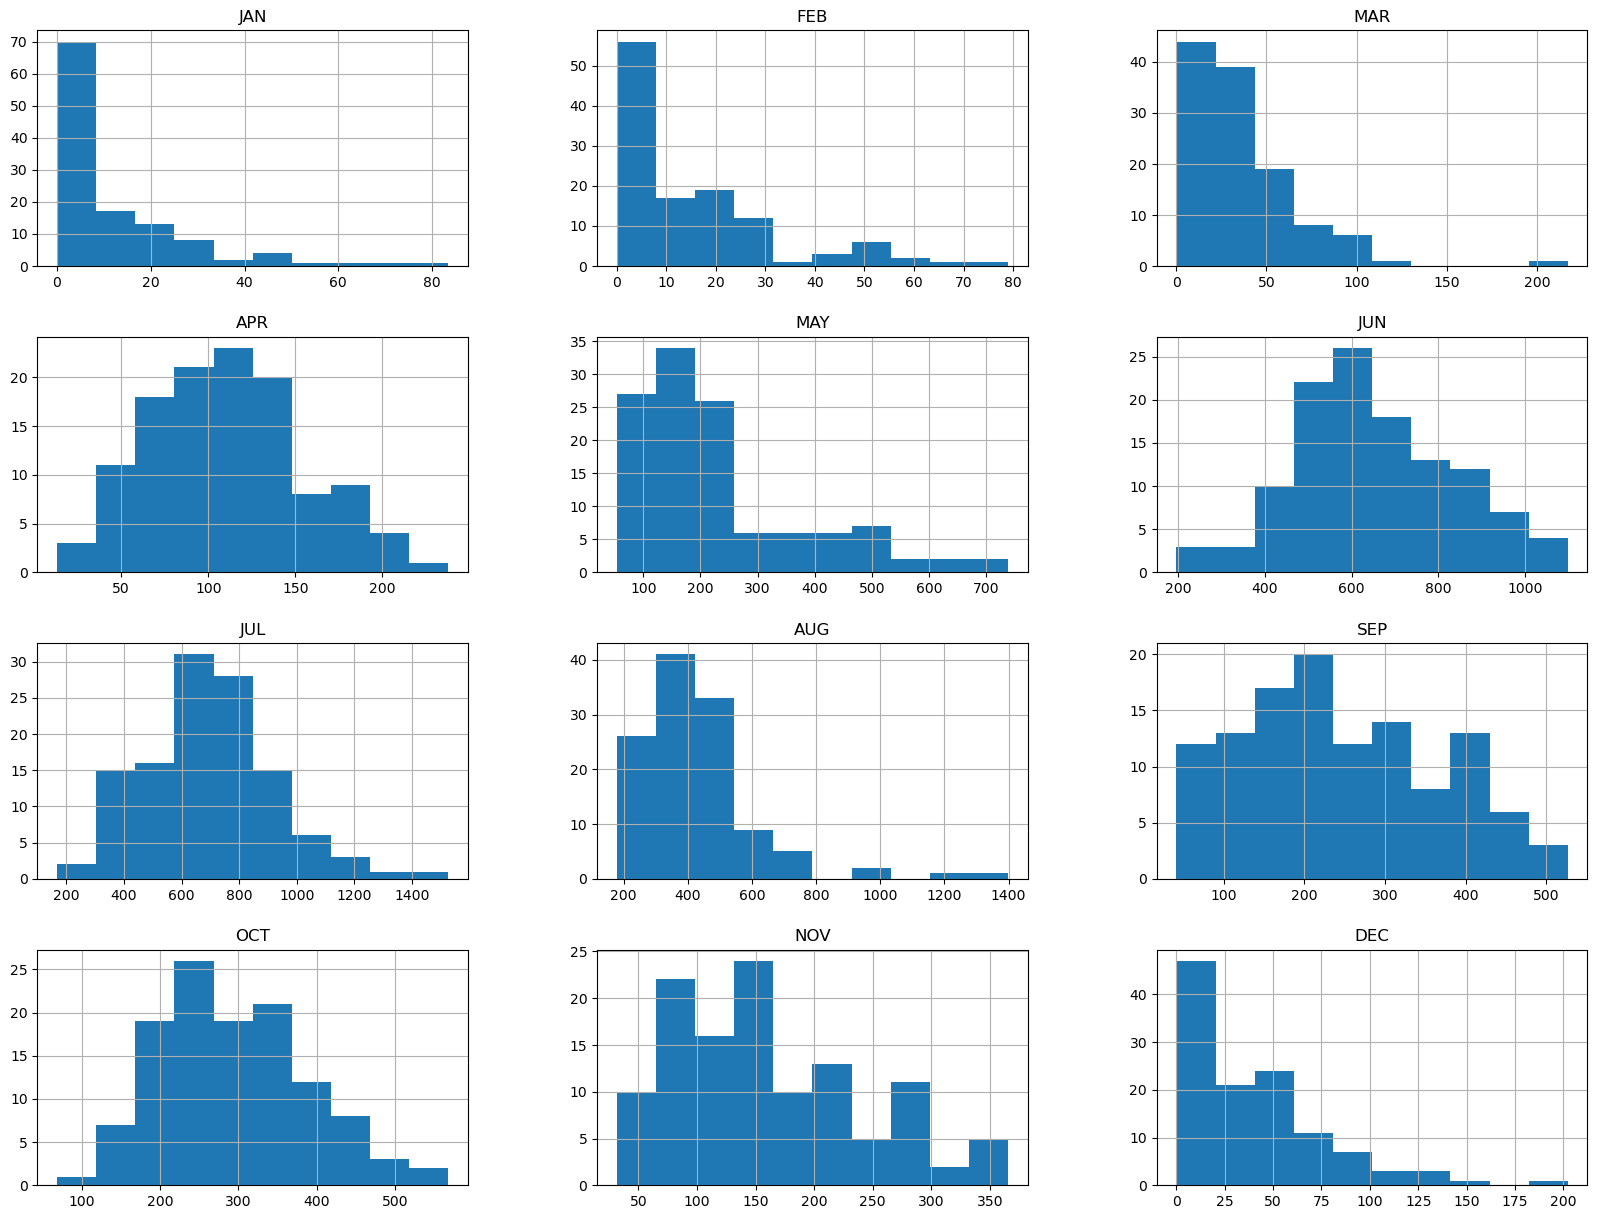

In [5]:
# see the distribution of the data for the different features
df.iloc[:, 2:14].hist(bins=10, figsize=(20,15))
plt.show()

We can see above how the rainfall is distributed for each month fpr all the years.

In [6]:
# display the unique values in the SUBDIVISION column
print(df[['SUBDIVISION']].value_counts())

SUBDIVISION
KERALA         117
KERALA           1
dtype: int64


We see that the SUBDIVISION has only one unique value so it is not very useful.

In [7]:
# encode the FLOODS feature with 0 and 1
df['FLOODS'] = df['FLOODS'].replace('YES', 1)
df['FLOODS'] = df['FLOODS'].replace('NO', 0)

# the following features are dropped as they are not required for training the model
df.drop(['SUBDIVISION', ' ANNUAL RAINFALL', 'YEAR'], axis=1, inplace=True)

In [8]:
# view the first 5 rows of the data
df.head()

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,FLOODS
0,28.7,44.7,51.6,160.0,174.7,824.6,743.0,357.5,197.7,266.9,350.8,48.4,1
1,6.7,2.6,57.3,83.9,134.5,390.9,1205.0,315.8,491.6,358.4,158.3,121.5,1
2,3.2,18.6,3.1,83.6,249.7,558.6,1022.5,420.2,341.8,354.1,157.0,59.0,1
3,23.7,3.0,32.2,71.5,235.7,1098.2,725.5,351.8,222.7,328.1,33.9,3.3,1
4,1.2,22.3,9.4,105.9,263.3,850.2,520.5,293.6,217.2,383.5,74.4,0.2,0


<AxesSubplot:>

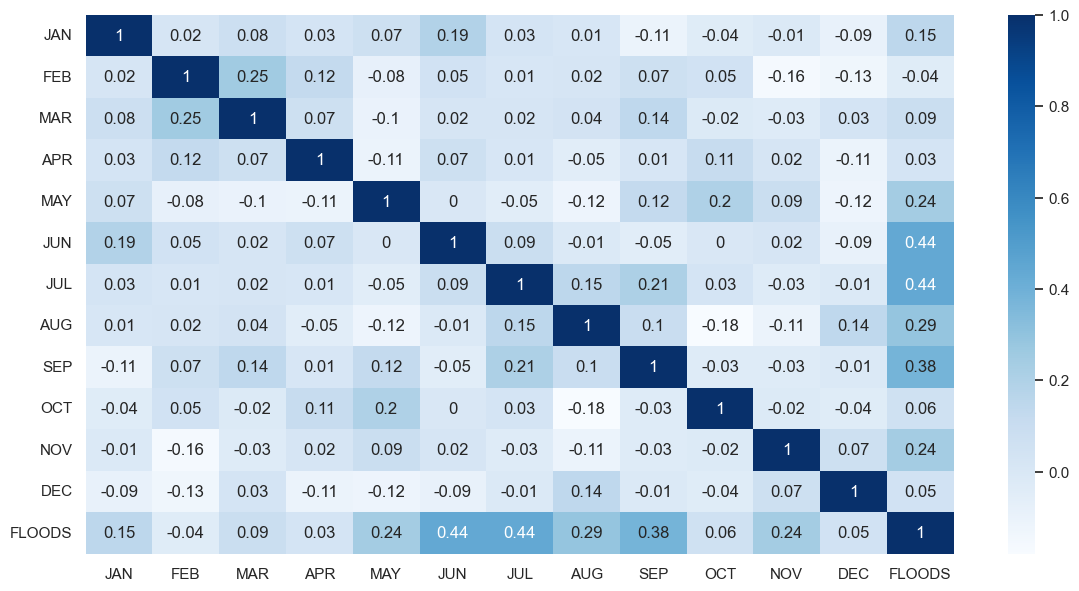

In [9]:
# display the heatmap of correlation between all features
corr_matrix = df.corr().round(2)
sns.set(font_scale=1)
plt.figure(figsize = (14,7))
sns.heatmap(corr_matrix, annot = True, cmap='Blues')

We can see the correlation between all the features above.\
The FLOODS target feature appears to be weakly correlated to the months from May to September.\
None of the features are strongly correlated with the FLOODS feature.\
This makes sense as it is the monsoon season during those months.

### Building the ANN Model

In [10]:
# import functions for preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [11]:
# store the features for prediction in X and the target class in y
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# use standard scaling to scale the data for training the model
std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.transform(X_test)

In [12]:
# import libraries for building the model
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.callbacks import EarlyStopping

In [43]:
# define the function to find the model with best hyperparameters for keras tuner
def ann_model_builder(hp):
    ann = Sequential()

    # hp_layer_1 = hp.Int('layer_1', min_value=1, max_value=13, step=1)
    hp_layer_2 = hp.Int('layer_2', min_value=1, max_value=101, step=10)
    hp_layer_3 = hp.Int('layer_3', min_value=1, max_value=101, step=10)
    hp_learning_rate = hp.Choice('learning_rate', values=[0.01, 0.001])

    ann.add(Dense(units=12, activation='relu'))
    ann.add(Dense(units=hp_layer_2, activation='relu'))
    ann.add(Dense(units=hp_layer_3, activation='relu'))
    ann.add(Dense(units=1, activation='sigmoid'))

    ann.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss=BinaryCrossentropy(), metrics=['accuracy'])

    return ann

In [44]:
# import keras tuner for hyperparameter tuning
import keras_tuner as kt

In [45]:
# define the tuner for finding the best hyperparameters
ktuner = kt.Hyperband(
    ann_model_builder,
    objective='val_accuracy',
    max_epochs=40,
    factor=3,
    directory='dir',
    project_name='ann_model',
    overwrite=True
)

In [46]:
# early stopping to stop training when val_loss is the same for 3 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [47]:
# search for the model with best hyperparameters
ktuner.search(X_train, y_train, epochs=50, validation_split=0.1, callbacks=[early_stopping])

Trial 90 Complete [00h 00m 02s]
val_accuracy: 0.8999999761581421

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 01m 46s
INFO:tensorflow:Oracle triggered exit


In [48]:
# get the best hyperparameters
best_hyperparameters = ktuner.get_best_hyperparameters(num_trials=1)[0]

In [49]:
# get and train the best model
ann_model =  ktuner.hypermodel.build(best_hyperparameters)
history = ann_model.fit(X_train, y_train, epochs=100, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/100
3/3 [==============================] - 1s 86ms/step - loss: 0.6845 - accuracy: 0.5357 - val_loss: 0.7053 - val_accuracy: 0.4000
Epoch 2/100
3/3 [==============================] - 0s 16ms/step - loss: 0.5286 - accuracy: 0.7857 - val_loss: 0.5796 - val_accuracy: 0.6000
Epoch 3/100
3/3 [==============================] - 0s 16ms/step - loss: 0.4121 - accuracy: 0.8452 - val_loss: 0.5291 - val_accuracy: 0.6000
Epoch 4/100
3/3 [==============================] - 0s 16ms/step - loss: 0.2917 - accuracy: 0.8810 - val_loss: 0.3079 - val_accuracy: 0.7000
Epoch 5/100
3/3 [==============================] - 0s 16ms/step - loss: 0.1888 - accuracy: 0.9286 - val_loss: 0.2273 - val_accuracy: 0.9000
Epoch 6/100
3/3 [==============================] - 0s 23ms/step - loss: 0.1011 - accuracy: 0.9524 - val_loss: 0.2533 - val_accuracy: 0.9000
Epoch 7/100
3/3 [==============================] - 0s 16ms/step - loss: 0.0433 - accuracy: 1.0000 - val_loss: 0.1651 - val_accuracy: 0.9000
Epoch 8/100
3/3 [===

In [51]:
# get the summary of the model
ann_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 12)                156       
                                                                 
 dense_5 (Dense)             (None, 61)                793       
                                                                 
 dense_6 (Dense)             (None, 91)                5642      
                                                                 
 dense_7 (Dense)             (None, 1)                 92        
                                                                 
Total params: 6,683
Trainable params: 6,683
Non-trainable params: 0
_________________________________________________________________


#### Get Predictions for the Testing set

In [52]:
# get the predictions for the testing set
y_pred = ann_model.predict(X_test)

1/1 [==============================] - 0s 40ms/step


In [53]:
# transform y_pred to run performance metrics on it with y_test
y_pred = (y_pred>0.5)
y_pred = y_pred.reshape(-1)
y_pred = y_pred.astype(int)

In [54]:
# import functions for performance metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

<AxesSubplot:>

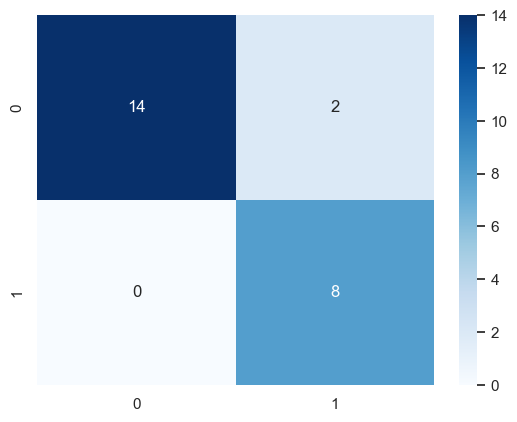

In [55]:
# plot the confustion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

In [56]:
# get the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.88      0.93        16
           1       0.80      1.00      0.89         8

    accuracy                           0.92        24
   macro avg       0.90      0.94      0.91        24
weighted avg       0.93      0.92      0.92        24



In [57]:
# get the accuracy and f1_score on the test set
print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))

Accuracy Score:  0.9166666666666666
F1 Score:  0.888888888888889


- The Accuracy score of the model is 91.67%.
- The F1 Score of the model is 89.0%.

In [61]:
# save the model for future use
ann_model.save('flood_prediction_model.h5')

---

## Time Series Model

In [1]:
# import all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sklearn
import itertools
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [2]:
# import the data
df1 = pd.read_csv("Monthly Rainfall Index Kerala Time Series.csv", index_col="Date", parse_dates=True)
df1.head()

,Rainfall(mm)
Date,
1901-01-01,28.7
1901-02-01,44.7
1901-03-01,51.6
1901-04-01,160.0
1901-05-01,174.7


In [3]:
# get a summary of the data
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1416 entries, 1901-01-01 to 2018-12-01
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rainfall(mm)  1416 non-null   float64
dtypes: float64(1)
memory usage: 22.1 KB


We see that there are no missing values

In [4]:
# get some basic statistics of the data
df1.describe()

,Rainfall(mm)
count,1416.000000
mean,243.786794
std,258.398667
min,0.000000
25%,35.275000
50%,154.700000
75%,371.350000
max,1526.500000


In [5]:
# split the data into training and testing sets
train = df1.iloc[:-36, :]
test = df1.iloc[-36:, :]

### Time Series Analysis

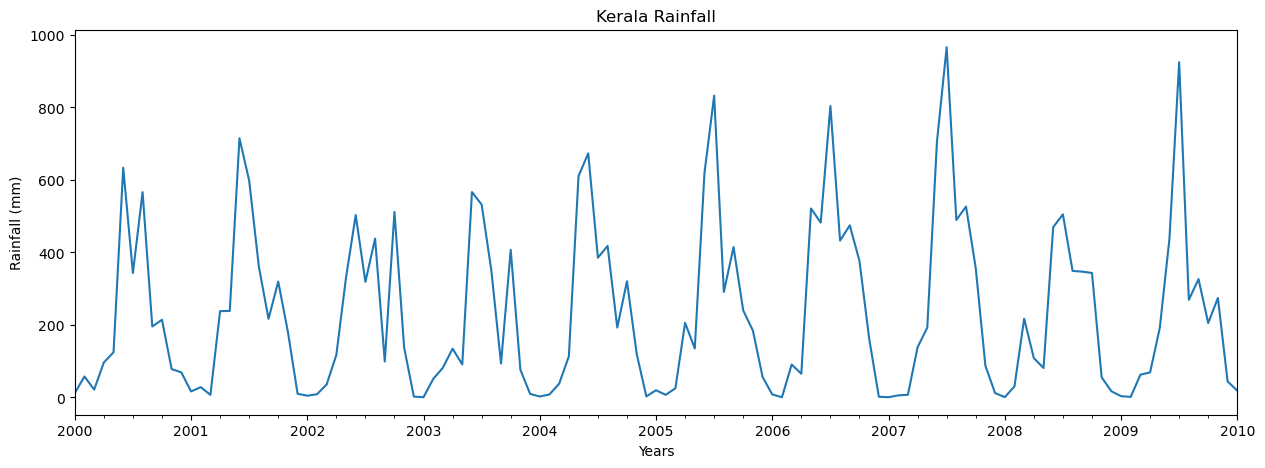

In [6]:
# plot the data for 10 years for better visibility
plt.figure(figsize=(15,5))
train['Rainfall(mm)']['2000-01-01':'2010-01-01'].plot()
plt.title('Kerala Rainfall')
plt.xlabel('Years')
plt.ylabel('Rainfall (mm)')
plt.show()

Some seasonality can be observed but it is not clear from this plot.\
The next plot showing monthly rainfall over all the years should make it more clear.

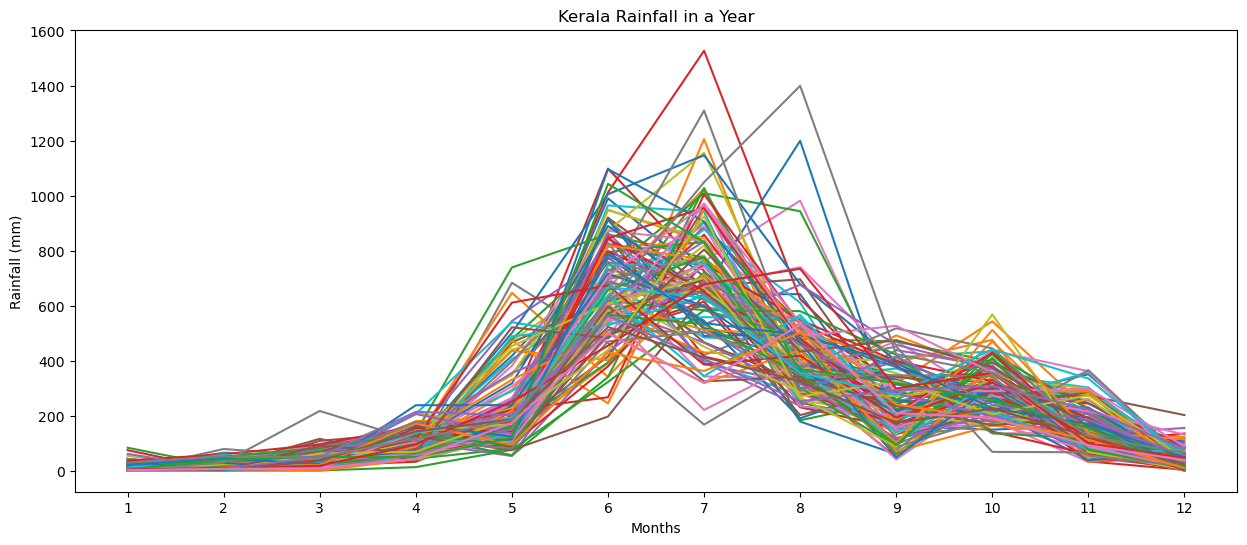

In [7]:
# plot the rainfall per month for all the years
df2 = df1.copy(deep=True)
df2['Month'] = df2.index.month
df2['Year'] = df2.index.year

df2_pivot_table = pd.pivot_table(df2, values='Rainfall(mm)', index='Month', columns='Year', aggfunc='mean')
df2_pivot_table.plot(figsize=(15,6), legend=False)
plt.title('Kerala Rainfall in a Year')
plt.xticks([x for x in range(1,13)])
plt.xlabel('Months')
plt.ylabel('Rainfall (mm)')
plt.show()


Seasonality can be better observed from the above plot. Rainfall increases from May onwards and starts to decreases from September onwards.

#### Stationarity Test

Stationarity test is a requirement for time series analysis. A time series is said to have stationarity if it's statistical properties do not change with time. The time series data must have stationarity to build the forecasting model required.

Stationarity of a time series can be determined in two ways:
1. Rolling Statistics Test: This is a visulization test that is used frequently to evaluate the time series data's regularity over time. A rolling window of size 12 is slid across the data, and the mean and standard deviation are calculated for each window. These are visualized in a plot and by comparing them with the original data, we can see if the data is stationary or not.

2. Augmented Dicky-Fuller Test: This is a statistical test that gives a p-value that will determine whether we can reject the null hypothesis that the time series is not stationary. The alternate hypthesis is that the time series is staionary. If the p-value is lower than the critical value of 0.05 or 0.01, then the null hypothesis is rejected and the time series is stationary.

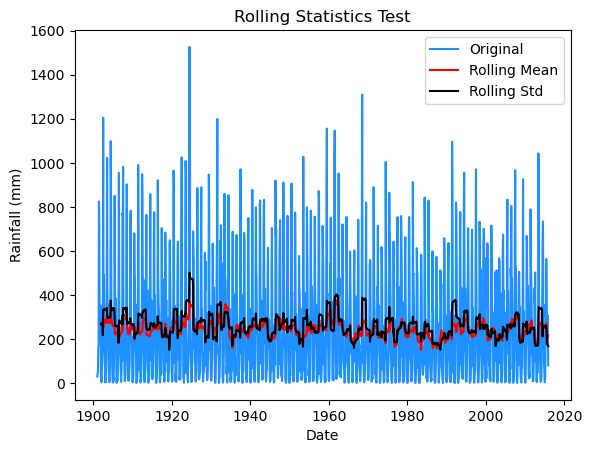

Augmented Dickey-Fuller Test:
ADF Statistic: -5.631022331891582
p-value: 1.0894572423811742e-06
Critical Values:
1% -3.4351852261663867
5% -2.863675384893896
10% -2.5679068804891


In [8]:
# Determine rolling mean and standard deviation
rolling_mean = train['Rainfall(mm)'].rolling(window=12).mean()
rolling_std = train['Rainfall(mm)'].rolling(window=12).std()

# Plot rolling statistics:
original = plt.plot(train['Rainfall(mm)'], color='dodgerblue',label='Original')
mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
std = plt.plot(rolling_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Statistics Test')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.show()
plt.show()

# Perform Augmented Dickey-Fuller test:
print('Augmented Dickey-Fuller Test:')
adfuller_test = adfuller(train['Rainfall(mm)'], autolag='AIC')
print(f'ADF Statistic: {adfuller_test[0]}')
print(f'p-value: {adfuller_test[1]}')
print('Critical Values:')
for key, value in adfuller_test[4].items():
        print(key, value)

- From the Rolling Statistics Test plot, we can see that the mean and standard deviation do not change much with respect to time.
- From the Augmented Dickey-Fuller test, ADF Statistic value is lower than the 1% and 5% critical values, and the p-value is 0.000001 which is much lower than 0.05.

We see from the two tests that the data has stationarity and no transformation has to be done to make it stationary.

#### Seasonal Decomposition

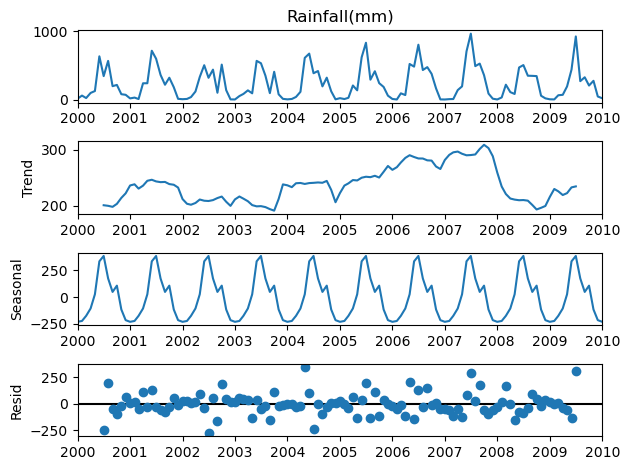

In [9]:
# plot the seasonality decomposition for 2000 to 2010
# for better visibility only 10 years of data are used
seasonal_decomposition = seasonal_decompose(train['Rainfall(mm)']['2000-01-01':'2010-01-01'], period = 12).plot()
plt.show()

We can observe that there is no trend but there is seasonality in the data, and so the seasonality will have to be taken into account when making the model for forecasting rainfall.

#### SARIMA (Seasonal Autoregressive Integrated Moving Average)

The SARIMA model is represented by the following variables: (p, d, q) (P, D, Q)m

(p, d, q) is the non-seasonal part of the model and (P, D, Q)m is the seasonal part.

To build the SARIMA model we are required to find the p, d, q, and m values to pass as parameters to the model.
- p - number of terms in autoregressive model
- d - differencing factor
- q - number of terms in moving average model

The P, D, and Q variables are seasonal elements similar to the p, d, and q values, and m is the number of observations in a seasonal time period.

To find the values of the variables, the Autocorrelation Function (ACF) and the Partial Autocorrelation Function (PACF) plots are used.

- ACF - computes the correlation between most recent and previous values of a single variable that also takes into account the translative effect of values that persist over time.
- PACF - computes the correlation between most recent and previous values without taking the translative effect into account. 

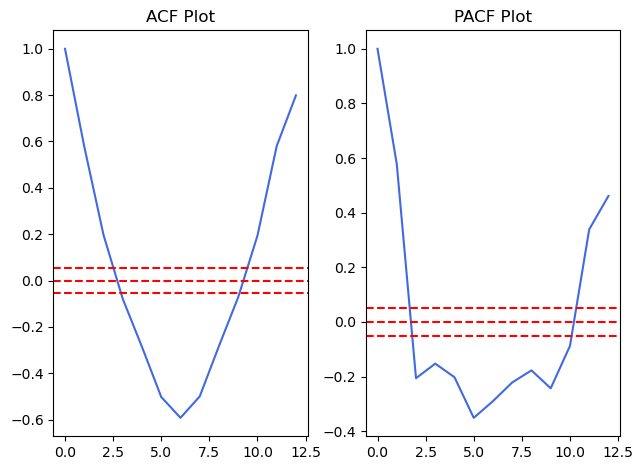

In [10]:
# plot the Autocorrelation function plot
acf = acf(train, nlags=12)
plt.subplot(121)
plt.plot(acf, color='royalblue')
plt.axhline(y=0, linestyle='--', color ='red')
plt.axhline(y=1.96/np.sqrt(len(train)), linestyle='--',color ='red')
plt.axhline(y=-1.96/np.sqrt(len(train)), linestyle='--',color ='red')
plt.title('ACF Plot')

# plot the Partial Autocorrelation plot
pacf = pacf(train, nlags=12, method='ols')
plt.subplot(122)
plt.plot(pacf, color='royalblue')
plt.axhline(y=0, linestyle='--', color ='red')
plt.axhline(y=1.96/np.sqrt(len(train)), linestyle='--',color ='red')
plt.axhline(y=-1.96/np.sqrt(len(train)), linestyle='--',color ='red')
plt.title('PACF Plot')
plt.tight_layout()

- The PACF plot is used to find the value for p, and it is the value where the line first comes into contact with the upper confidence interval.
- The ACF plot is used to find the value for q, and it is the value where the line first comes into contact with the upper confidence interval.

The above ACF and PACF plots show that p is 2 and q is 3. The value of d is 0 since there was no differencing done on the time series.

To find the best values of p, d, and q for the model a grid search will be done to find the best combination of values, which will then be used to build the model. 

The Akaike Information Criteria (AIC) will be used to determine which combination of values is the best. AIC is a method that is commonly employed for evaluating and selecting the best fitting model for a dataset. Lower AIC means a model that is fitting better. 

##### Hyperparameter tuning

In [11]:
# resample the data based on month start with the mean rainfall of each month
train_sarima = train.resample("MS").mean() 
train_sarima = train_sarima[["Rainfall(mm)"]]

In [12]:
# p, d, and q are any values from 0 to 3
p = d = q = range(0, 4)

# get all combinations of p, d, and q
pdq = list(itertools.product(p, d, q))

# get all comibinations of p, d, q and m = 12 
s_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [14]:
# find the best combination with lowest AIC score
min_aic = 10**5
for val in pdq:
    for val_seasonal in s_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(
                train_sarima,
                order=val,
                seasonal_order=val_seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False
            )

            results = mod.fit()

            if (results.aic <= min_aic):
                min_aic = results.aic
                print('SARIMA:{}x{} - AIC:{}'.format(val, val_seasonal, results.aic))

        except:
            continue

SARIMA:(0, 0, 0)x(0, 0, 0, 12) - AIC:20107.237637268718
SARIMA:(0, 0, 0)x(0, 0, 1, 12) - AIC:19011.34750228115
SARIMA:(0, 0, 0)x(0, 0, 2, 12) - AIC:18364.314082955185
SARIMA:(0, 0, 0)x(0, 0, 3, 12) - AIC:17928.723315635427
SARIMA:(0, 0, 0)x(0, 1, 0, 12) - AIC:17780.003739578613
SARIMA:(0, 0, 0)x(0, 1, 1, 12) - AIC:16832.71305768952
SARIMA:(0, 0, 0)x(0, 1, 2, 12) - AIC:16702.04625258364
SARIMA:(0, 0, 0)x(0, 1, 3, 12) - AIC:16524.348148101133
SARIMA:(0, 0, 0)x(0, 2, 3, 12) - AIC:16510.58304779447
SARIMA:(0, 0, 0)x(1, 2, 3, 12) - AIC:16502.639154831795
SARIMA:(0, 0, 0)x(2, 2, 3, 12) - AIC:16487.989221504664
SARIMA:(0, 0, 1)x(1, 2, 3, 12) - AIC:16477.81021288278
SARIMA:(0, 0, 3)x(1, 2, 3, 12) - AIC:16458.835749359117


From the search we see that the combination of (0, 0, 3)x(1, 2, 3, 12) has the lowest AIC score of 16458.835749359117 which makes the best. So this combination will be used for the SARIMA model

##### Building the model with best hyperparameters

In [13]:
# build model with best hyperparameters
model = sm.tsa.statespace.SARIMAX(
    train_sarima,
    order=(0, 0, 3),
    seasonal_order=(1, 2, 3, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()

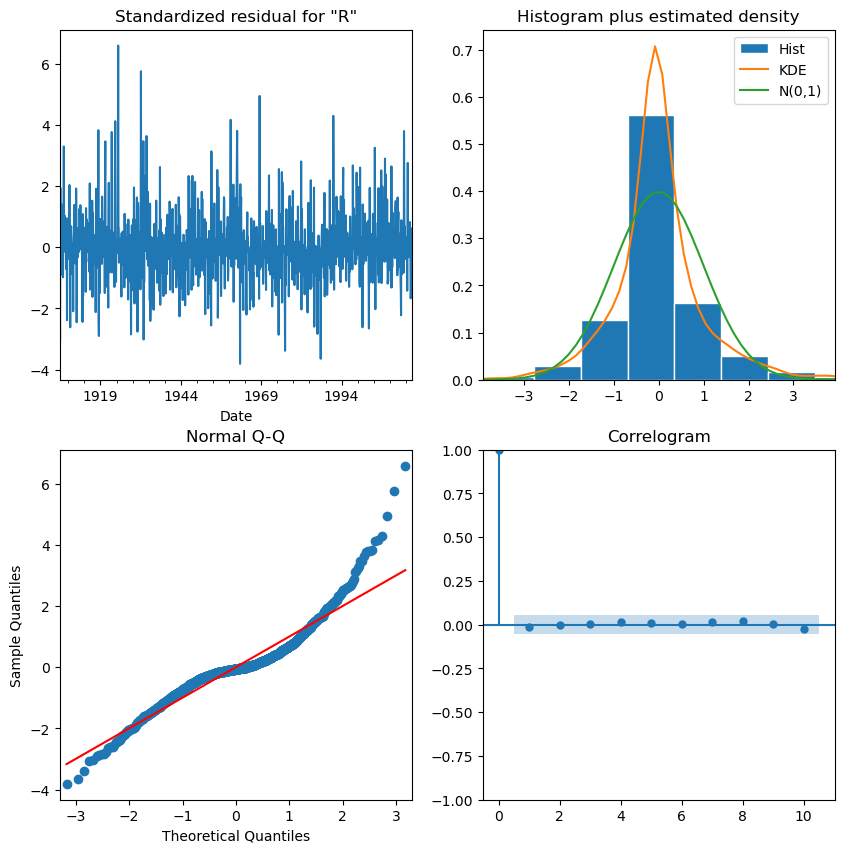

In [14]:
results.plot_diagnostics(figsize=(10, 10))
plt.show()

From the above plots we can see:
- In the Histogram plus estimated density plot, the Kernel Desnity Estimator (KDE) line has a similar distribution to the normal distribution N(0,1) line.
- In the Normal Q-Q plot, the residuals appear to follow a normal distribution.
- In the Correlogram plot which is the Autocorrelation Function plot, the residuals have low correlations with it's own lagged time series.

##### Prediction on Training Set

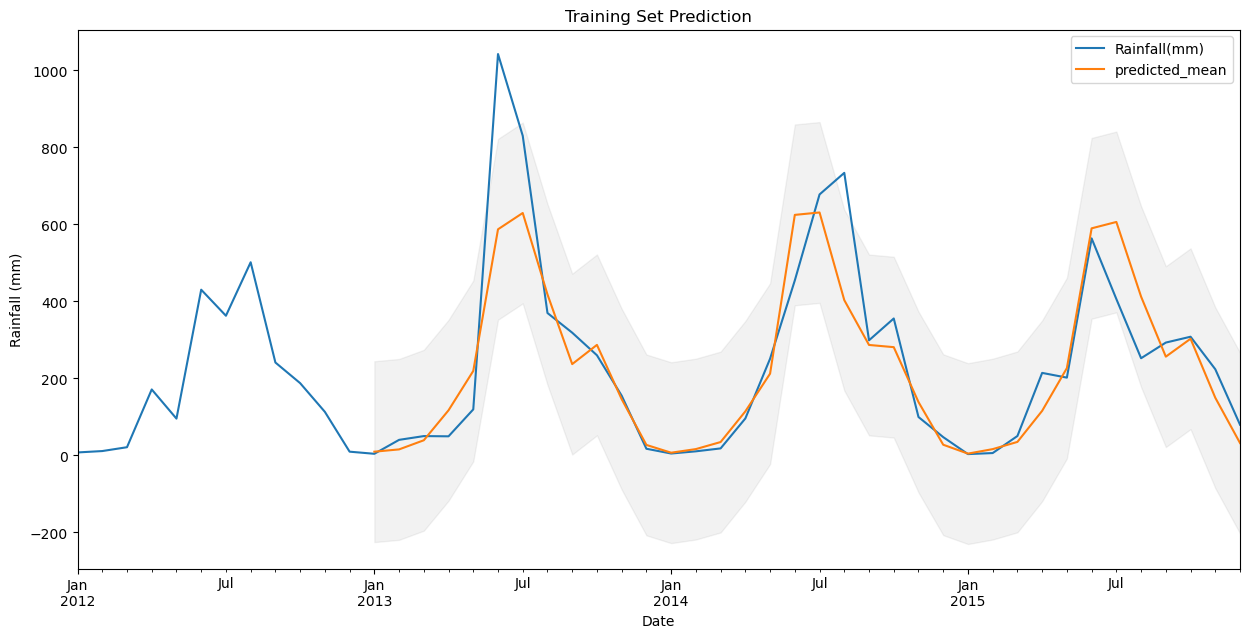

In [15]:
# Predictions are performed for the 1st January 2013 onwards of the train data.
train_pred = results.get_prediction(start = pd.to_datetime('2013-01-01'), dynamic = False) 

# Get confidence intervals of predictions
train_pred_ci = train_pred.conf_int() 

ax = train_sarima["2012":].plot(label="observed", figsize=(15, 7))
train_pred.predicted_mean.plot(ax = ax, alpha = 1, legend = True)
ax.fill_between(
    train_pred_ci.index, 
    train_pred_ci.iloc[:, 0], 
    train_pred_ci.iloc[:, 1], 
    color = "k", 
    alpha = 0.05
)
ax.set_xlabel("Date")
ax.set_ylabel("Rainfall (mm)")
plt.title('Training Set Prediction')
plt.show()

##### RMSE and R2 of Prediction on Training Set

In [16]:
train_sarima_prediction = train_pred.predicted_mean
train_sarima_true = train_sarima["2013-01-01":]

# Calculating the RMSE
rmse_train = sqrt(mean_squared_error(train_sarima_true, train_sarima_prediction))
r2_train = r2_score(train_sarima_true, train_sarima_prediction)
print(f"Root Mean Squared Error: {rmse_train}")
print(f"R2 Score: {r2_train}")

Root Mean Squared Error: 118.96432178680983
R2 Score: 0.7787422840632147


##### Prediction on Testing Set

In [17]:
# put the test dataset into a pandas Series
test_predictions = pd.Series(results.predict(start = len(train), end = len(train)+len(test)-1))
test_predictions.index = test.index
test_predictions.head()

Date
2016-01-01      7.491772
2016-02-01     12.736337
2016-03-01     33.237158
2016-04-01    119.192628
2016-05-01    212.459082
Name: predicted_mean, dtype: float64

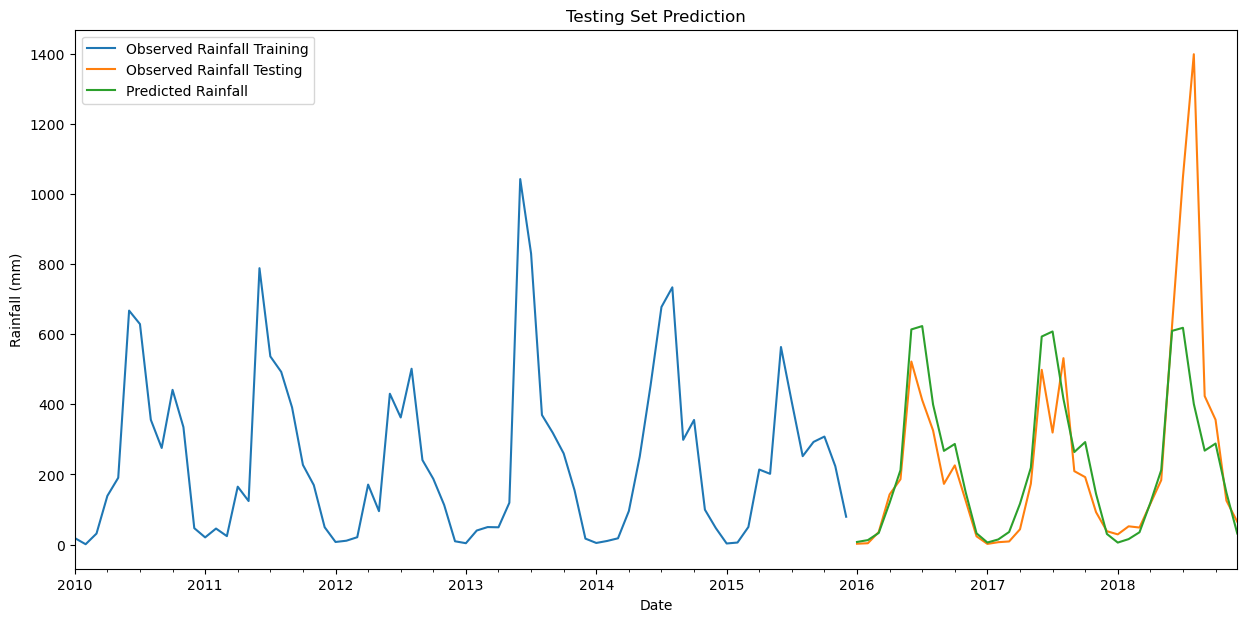

In [18]:
train['Rainfall(mm)']['2010-01-01':].plot(figsize=(15,7), legend=True, label="Observed Rainfall Training")
test['Rainfall(mm)'].plot(legend=True, label="Observed Rainfall Testing")
test_predictions.plot(legend=True, label="Predicted Rainfall")
plt.title('Testing Set Prediction')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.show()

##### RMSE and R2 of Prediction on Testing Set

In [19]:
test_sarima_prediction = test_predictions
test_sarima_true = test

# Calculate the RMSE
rmse_test = sqrt(mean_squared_error(test_sarima_true, test_sarima_prediction))
r2_test = r2_score(test_sarima_true, test_sarima_prediction)
print(f"Root Mean Squared Error: {rmse_test}")
print(f"R2 Score: {r2_test}")

Root Mean Squared Error: 198.37873977732943
R2 Score: 0.5501659722276875


##### Get The Prediction for 2023

In [20]:
results.predict(start = len(train)+len(test)+48, end = len(train)+len(test)+60-1)

2023-01-01      5.192160
2023-02-01     14.910600
2023-03-01     35.728264
2023-04-01    117.897430
2023-05-01    214.175069
2023-06-01    594.710703
2023-07-01    602.725685
2023-08-01    409.395325
2023-09-01    268.668042
2023-10-01    292.312034
2023-11-01    144.553576
2023-12-01     29.702469
Freq: MS, Name: predicted_mean, dtype: float64

## Future Flood Prediction for 2023

In [1]:
# import the required libraries
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
# load the ANN model
flood_prediction_model = keras.models.load_model('flood_prediction_model.h5')

In [3]:
df = pd.read_csv("Monthly Rainfall Index and Flood Probability Kerala.csv")

df['FLOODS'] = df['FLOODS'].replace('YES', 1)
df['FLOODS'] = df['FLOODS'].replace('NO', 0)
df.drop(['SUBDIVISION', ' ANNUAL RAINFALL', 'YEAR'], axis=1, inplace=True)

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)

In [4]:
# store the 2023 data into a DataFrame
df_rainfall_2023 = pd.DataFrame(
    np.array([[5.192160, 14.910600, 35.728264, 117.897430, 214.175069, 594.710703, 
    602.725685, 409.395325, 268.668042, 292.312034, 144.553576, 29.702469]]), 
    columns=['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
)

df_rainfall_2023

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,5.19216,14.9106,35.728264,117.89743,214.175069,594.710703,602.725685,409.395325,268.668042,292.312034,144.553576,29.702469


In [5]:
# make the prediction for the 2023 data
print(flood_prediction_model.predict(std_scaler.transform(df_rainfall_2023.iloc[:, :].values)))

1/1 [==============================] - 0s 137ms/step
[[2.200484e-05]]


In [6]:
# get the flood prediction for 2023 data
pred = flood_prediction_model.predict(std_scaler.transform(df_rainfall_2023.iloc[:, :].values))

if (pred > 0.5):
    print("A flood is predicted for 2023")
else:
    print("No flood is predicted for 2023")

1/1 [==============================] - 0s 28ms/step
No flood is predicted for 2023


---